<a href="https://colab.research.google.com/github/guyzamos/MS_prediction/blob/main/MS_project_predict_Nitzan_data_specificity_sensitivity_all_experiments_with_EDSS_at_sample_date.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import all the relevant libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statistics as stats
import io
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split


upload the db file

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

read the file and create data frame

# helper functions

In [ ]:
def calcCrossValidation_Matrix(model, df, predictors, outcome):

  total_tp = 0
  total_tn = 0
  total_fp = 0
  total_fn = 0

  # Perform k-fold cross-validation with 10 folds
  kf = KFold(n_splits=df.shape[0])
  accuracy = []
  for train, test in kf.split(df):
      # print("1")

      # Filter training data
      train_predictors = (df[predictors].iloc[train, :])
      # The target we're using to train the algorithm.
      train_target = df[outcome].iloc[train]
      # print("1")

      test_predictors = (df[predictors].iloc[test, :])
      # The target we're using to train the algorithm.
      test_target = df[outcome].iloc[test]
      # print("1")


      # Training the algorithm using the predictors and target.
      model.fit(train_predictors, train_target)
      predictions = model.predict(test_predictors)
      # cm = confusion_matrix(test_target, predictions)
      # print(cm)
      # print("1")
      # print("test_target")
      test_target = test_target.to_numpy()
      # print(test_target)
      # np.array(df[outcome].values.tolist())
      # print(type(test_target))
      # print("predictions")
      # print(predictions)
      # print(type(predictions))

      tn, fp, fn, tp = perf_measure(test_target, predictions)
      # print("1")

      total_tp += tp
      total_tn += tn
      total_fp += fp
      total_fn += fn

  # print(total_tn, total_fp, total_fn, total_tp)
  return total_tn, total_fp, total_fn, total_tp 

In [ ]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    # print(TN, FP, FN, TP)
    return(TN, FP, FN, TP)

In [ ]:
def calc_specificity(tn, fp, fn, tp):
  return tn / (tn +fp)

In [ ]:
def calc_sensitivity(tn, fp, fn, tp):
  return tp / (tp +fn)

#Nitzan experiments - with EDSS at sample date

In [ ]:
const_seed = 42

In [ ]:
df_untreated = pd.read_pickle("/content/gdrive/My Drive/Colab Notebooks/MS_Notebooks/DFDB1Final.pkl")


print(df_untreated.shape[0])


57


In [ ]:
df_untreated.shape

(57, 36)

In [ ]:
# categorical_features = ['gender','oligoclonal_band','diagnosis']
# df_untreated = pd.get_dummies(df_untreated, columns=categorical_features, drop_first=True)
# df_untreated.drop(['treatment_when_sample_was_taken', 'sample_code'], axis='columns', inplace=True)
df_untreated = df_untreated[['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','1_years_EDSS','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total', 'SPMS']]
df_untreated


In [ ]:
df_untreated.shape

(57, 17)

In [ ]:
df_untreated.columns.values

array(['MRI_lesion_mass', 'primary_EDSS_at_diagnosis',
       'primary_EDSS_at_sample_date', '1_years_EDSS', 'age_at_diagnosis',
       'TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male',
       'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN',
       'med_TYSABRI', 'cells_total', 'SPMS'], dtype=object)

all features

In [ ]:
def min_max_normalize_features(dataframe, numeric_list):
    for num_feature in numeric_list:
        dataframe[num_feature] = (dataframe[num_feature] - dataframe[num_feature].min()) / (
                dataframe[num_feature].max() - dataframe[num_feature].min())
    return dataframe

In [ ]:
numeric_features = ['MRI_lesion_mass', 'primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ','TIGIT_RQ','LAG3_RQ','PD-1_RQ']
df_untreated = min_max_normalize_features(df_untreated, numeric_features)
df_untreated

In [ ]:
df_untreated.columns

Index(['MRI_lesion_mass', 'primary_EDSS_at_diagnosis',
       'primary_EDSS_at_sample_date', '1_years_EDSS', 'age_at_diagnosis',
       'TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB',
       'OTHER_TREATMENT', 'UNTREATED', 'med_IFN', 'med_TYSABRI', 'cells_total',
       'SPMS'],
      dtype='object')

all features

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))
coefficients = pd.concat([pd.DataFrame(predictor_var1), pd.DataFrame(np.transpose(logisticRegrDF.coef_))], axis=1)
coefficients.columns = ['feature_name', 'coefficient_val']
coefficients = coefficients.sort_values(by=['coefficient_val'], ascending=False)
coefficients.to_excel('coef_no_abs.xlsx')
coefficients['coefficient_val'] = coefficients['coefficient_val'].abs()

coefficients = coefficients.sort_values(by=['coefficient_val'], ascending=False)
coefficients.to_excel('coef_abs.xlsx')

print(coefficients)


0.9428571428571428
0.7272727272727273
                   feature_name  coefficient_val
2   primary_EDSS_at_sample_date         2.118495
1     primary_EDSS_at_diagnosis         1.678052
3              age_at_diagnosis         1.098005
8                          Male         0.731981
4                       TIM3_RQ         0.731165
0               MRI_lesion_mass         0.618647
6                       LAG3_RQ         0.518805
9                  positive_OCB         0.449617
7                       PD-1_RQ         0.148516
11                    UNTREATED         0.133040
13                  med_TYSABRI         0.131766
14                  cells_total         0.085247
10              OTHER_TREATMENT         0.074264
12                      med_IFN         0.072873
5                      TIGIT_RQ         0.046091


0.9428571428571428
0.6818181818181818
Feature ranking:
1. feature 2 primary_EDSS_at_sample_date (0.320035)
2. feature 1 primary_EDSS_at_diagnosis (0.224224)
3. feature 3 age_at_diagnosis (0.127940)
4. feature 5 TIGIT_RQ (0.066962)
5. feature 4 TIM3_RQ (0.060228)
6. feature 6 LAG3_RQ (0.056303)
7. feature 0 MRI_lesion_mass (0.046665)
8. feature 7 PD-1_RQ (0.030398)
9. feature 14 cells_total (0.025437)
10. feature 8 Male (0.019519)
11. feature 9 positive_OCB (0.007048)
12. feature 10 OTHER_TREATMENT (0.006859)
13. feature 11 UNTREATED (0.004946)
14. feature 12 med_IFN (0.001781)
15. feature 13 med_TYSABRI (0.001655)


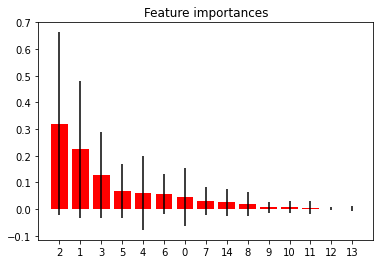

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier


rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))
# importances = rf.feature_importances_
# importances
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(predictor_var1)):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f],predictor_var1[indices[f]], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(predictor_var1)), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(len(predictor_var1)), indices)
plt.xlim([-1, len(predictor_var1)])
plt.show()


no genes

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))
coefficients = pd.concat([pd.DataFrame(predictor_var1), pd.DataFrame(np.transpose(logisticRegrDF.coef_))], axis=1)
coefficients.columns = ['feature_name', 'coefficient_val']
coefficients = coefficients.sort_values(by=['coefficient_val'], ascending=False)
coefficients.to_excel('coef_no_abs.xlsx')
coefficients['coefficient_val'] = coefficients['coefficient_val'].abs()

coefficients = coefficients.sort_values(by=['coefficient_val'], ascending=False)
coefficients.to_excel('coef_abs.xlsx')

print(coefficients) 

0.9428571428571428
0.7272727272727273
                   feature_name  coefficient_val
2   primary_EDSS_at_sample_date         2.134237
1     primary_EDSS_at_diagnosis         1.637731
3              age_at_diagnosis         1.117041
4                          Male         0.773730
0               MRI_lesion_mass         0.720542
5                  positive_OCB         0.454888
7                     UNTREATED         0.170233
6               OTHER_TREATMENT         0.120862
9                   med_TYSABRI         0.114863
10                  cells_total         0.076049
8                       med_IFN         0.065452


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.7727272727272727


no TIM3

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))


0.9428571428571428
0.7272727272727273


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.6818181818181818


no TIGIT_RQ

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))
coefficients = pd.concat([pd.DataFrame(predictor_var1), pd.DataFrame(np.transpose(logisticRegrDF.coef_))], axis=1)
coefficients.columns = ['feature_name', 'coefficient_val']
coefficients = coefficients.sort_values(by=['coefficient_val'], ascending=False)
coefficients.to_excel('coef_no_abs.xlsx')
coefficients['coefficient_val'] = coefficients['coefficient_val'].abs()

coefficients = coefficients.sort_values(by=['coefficient_val'], ascending=False)
coefficients.to_excel('coef_abs.xlsx')

print(coefficients)

0.9714285714285714
0.7272727272727273
                   feature_name  coefficient_val
2   primary_EDSS_at_sample_date         2.117434
1     primary_EDSS_at_diagnosis         1.677473
3              age_at_diagnosis         1.098721
4                       TIM3_RQ         0.737167
7                          Male         0.727884
0               MRI_lesion_mass         0.624061
5                       LAG3_RQ         0.509681
8                  positive_OCB         0.448264
6                       PD-1_RQ         0.148776
10                    UNTREATED         0.134546
12                  med_TYSABRI         0.133666
13                  cells_total         0.085046
9               OTHER_TREATMENT         0.074424
11                      med_IFN         0.073361


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.6363636363636364


no LAG3

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9428571428571428
0.6818181818181818


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.6363636363636364


no TIM3 and LAG3

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis', 'TIGIT_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))


0.9428571428571428
0.6818181818181818


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis', 'TIGIT_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.8571428571428571
0.6818181818181818


no TIM3 and TIGIT

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))


0.9428571428571428
0.7272727272727273


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.8857142857142857
0.6818181818181818


no LAG3 and TIGIT

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))


0.9428571428571428
0.6818181818181818


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.8857142857142857
0.6818181818181818


no MRI

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))


0.9142857142857143
0.6818181818181818


In [ ]:
df_untreated.shape

(57, 17)

In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.8571428571428571
0.7272727272727273


no OCB

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9714285714285714
0.6363636363636364


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.6818181818181818


no total cells

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9428571428571428
0.6818181818181818


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.8857142857142857
0.6818181818181818


no PD1

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9428571428571428
0.7272727272727273


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['MRI_lesion_mass','primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.6818181818181818


no MRI, OCB

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9714285714285714
0.6818181818181818


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.6363636363636364


no MRI, LAG3

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.7272727272727273


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'TIGIT_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.8857142857142857
0.7272727272727273


no MRI, TIGIT

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.6818181818181818


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.7727272727272727


no MRI, TIM3, LAG3

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIGIT_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.7272727272727273


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIGIT_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.7272727272727273


no MRI, TIM3, TIGIT

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.7272727272727273


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis', 'LAG3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.7272727272727273


no MRI, TIGIT, LAG3

In [ ]:
from sklearn.metrics import confusion_matrix

logisticRegrDF = LogisticRegression(max_iter = 4000,random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(logisticRegrDF, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9428571428571428
0.7272727272727273


In [ ]:
from sklearn.metrics import confusion_matrix

rf = RandomForestClassifier(n_estimators=25, min_samples_split=9, max_depth=15, max_features='auto',random_state=const_seed)
predictor_var1 = ['primary_EDSS_at_diagnosis','primary_EDSS_at_sample_date','age_at_diagnosis','TIM3_RQ', 'PD-1_RQ', 'Male', 'positive_OCB', 'OTHER_TREATMENT', 'UNTREATED', 'med_IFN','med_TYSABRI','cells_total']
outcome_var = 'SPMS'
tn, fp, fn, tp = calcCrossValidation_Matrix(rf, df_untreated, predictor_var1, outcome_var)
print(calc_specificity(tn, fp, fn, tp))
print(calc_sensitivity(tn, fp, fn, tp))

0.9142857142857143
0.7272727272727273
